L'objectif de ce notebook est d'illustrer le principe des GAN (*Generative Adversarial Networks*). Le GAN est un échange entre deux réseaux :    
* Le générateur : son objectif est à partir de données aléatoires de générer des images qui sont le plus similaires possibles d'un jeu de données
* Le discriminteur : son objectif est de parer les fausses images générées et d'éviter que celles-ci soient considérées comme vraies.     

Les deux réseaux vont donc chacun faire en sorte de gagner : le générateur va essayer de générer des images les plus vraisemblables et le discriminateur va essayer de voir si les images générées sont vraies ou fausses.   

Le principe est résumé sur la figure suivante :      

<IMG SRC="http://www.lirmm.fr/~poncelet/Ressources/ArchitectureGAN
" align="center" >

A partir de données aléatoires, i.e. Random Noise, le générateur va générer des données. Ces dernières sont combinées à des données réelles et sont envoyées dans le discriminateur. L'objectif du discriminateur est alors de déterminer s'il s'agit de données réelles ou de fausses données. Il fait une classification binaire : données réelles ou données fausses. Bien entendu le générateur fait en sorte que les données générées aient le même label que les données réelles.    

De manière à générer des données assez similaires aux réelles, le principe est le suivant : l'erreur à la fin du discriminateur est reportée au niveau du générateur afin qu'il mette ses poids à jour ... donc au fur et à mesure des epochs, la loss est projetée vers le générateur. Par contre il faut faire attention à ne pas projeter l'erreur du générateur à l'issue du modèle GAN au niveau du discriminateur ! toutes ces étapes sont illustrées par la suite.


## Installation

Avant de commencer, il est nécessaire de déjà posséder dans son environnement toutes les librairies utiles. Dans la seconde cellule nous importons toutes les librairies qui seront utiles à ce notebook. Il se peut que, lorsque vous lanciez l'éxecution de cette cellule, une soit absente. Dans ce cas il est nécessaire de l'installer. Pour cela dans la cellule suivante utiliser la commande :
! pip install nom_librairie
Attention : il est fortement conseillé lorsque l'une des librairies doit être installer de relancer le kernel de votre notebook.
Remarque : même si toutes les librairies sont importées dès le début, les librairies utiles pour des fonctions présentées au cours de ce notebook sont ré-importées de manière à indiquer d'où elles viennent et ainsi faciliter la réutilisation de la fonction dans un autre projet.

In [1]:
# utiliser cette cellule pour installer les librairies manquantes
# pour cela il suffit de taper dans cette cellule : !pip install nom_librairie_manquante
# d'exécuter la cellule et de relancer la cellule suivante pour voir si tout se passe bien
# recommencer tant que toutes les librairies ne sont pas installées ...

In [2]:
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from tensorflow.keras.layers import Dense, BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model


In [3]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML_FDS'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/ML_FDS


'/content/gdrive/My Drive/Colab Notebooks/ML_FDS'

Tout d'abord nous allons créer un générateur. Celui-ci va prendre en entrée un vecteur de données générées aléatoirement de taille latent_dim. Généralement latent_dim est mis à 100 mais d'autres valeurs sont bien sûr possibles. Il suffit après de mettre au bon format. Pour le générer nous utiliserons par exemple  :   

    np.random.randn(latent_dim * nombre d'exemples) ou np.random.normal(0,1, latent_dim)   

Il va donc falloir traduire ce vecteur en tableau 2D de 28x28 (784 valeurs) à la sortie du générateur, i.e. il s'agit d'une image qui sera passé au discriminateur. Pour simplifier nous considérons que la couche d'entrée est une couche dense (il est possible de rentrer directement sur une convolution en transformant d'abord le vecteur d'entrée). Pour déterminer le nombre de neurones de la couche dense L'entrée du générateur étant un vecteur, nous allons utiliser une couche dense. Il existe plusieurs moyens de déterminer le nombre de neurones de cette couche d'entrée.  

Ici nous allons utiliser du sur-échantillonage (*Conv2DTranspose*): l'idée est de ne générer qu'une partie de l'image et après de la dupliquer. Pour cela nous savons que la moitié d'une image fait 14×14 (soit 196 neurones), pour un quart de l'image nous avons donc 7x7 (49 neurones). Nous avons vu que les convolutions vont rechercher des motifs dans des images. Avec 49 neurones nous ne permettrons pas de faire de la convolution alors nous allons multiplier par un nombre qui permettent au réseau de faire des convolutions (en gros nous permettons d'avoir plusieurs images). Par exemple ici nous prenons 128 mais nous aurions pu mettre 256.   

Notre réseau au début va ressembler à  :   

    model = Sequential()
    # On considère 1/4 de l'image (7x7)
    # On multiplie par 128
    # le nombre de neurones est donc 
	  n_nodes = 128 * 7 * 7
	  model.add(Dense(n_nodes, input_dim=latent_dim))
    # Nous avons besoin d'une fonction d'activation
    # ici nous prenons LeakyRely (à la place de 0 comme dans 
    # Relu, la valeur retournée sera alpha) qui évite des problèmes de mort de neurones
	  model.add(LeakyReLU(alpha=0.2))
    
    
Par la suite nous allons faire passer cette couche vers une convolution, pour cela il est nécessaire de changer le shape de la couche de sortie :  

    model.add(reshape((7,7,128))  

Il ne reste plus qu'à agrandir l'image (sur-échantillonage) avec la fonction Conv2DTranspose. Elle ressemble à une convolution normale et le stride (2x2) permet de quadrupler l'image (double la hauteur et la largeur)  :      

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
    # ici la sortie de l'image sera de 14x14 il faut le refaire pour avoir une image de taille 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))


Il suffit à la fin de mettre une couche de sortie avec une sigmoid ou une autre fonction d'activation comme tanh (pour avoir des valeurs comprises entre 0 et 1). Ici nous avons un seul feature map en sortie Attention ne pas mettre un softmax car lors de la rétro-propagation du gradient le softmax ne se dérive pas simplement (c'est pourquoi la génération de textes est plus compliquée avec des GAN !).    

    model.add(Conv2D(1, (7,7), activation='sigmoid',   padding='same'))   

Remarque nous aurions pu finir au second Conv2Dtranspose qui possède une sortie de la bonne taille : 28x28 et simplement mettre une fonction d'activation tanh dans la convolution.



In [5]:
# Chargement des données
def load_data():
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (X_trainX, _), (_, _) = fashion_mnist.load_data()
  # Ajout d'une dimension pour le canal (1)
  X = expand_dims(trainX, axis=-1)
  # Normalisation
  X = X.astype('float32')
  # scale from [0,255] to [0,1]
  X = X / 255.0
  return X

La fonction ci-dessous reprend le générateur. Nous avons ajouté des BatchNormalization pour faciliter l'apprentissage :

In [6]:
def create_generator(latent_dim=100):
  model = Sequential()
	# 1/4 de l'image (7x7) * nombre d'images possibles
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization()) 		
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

La définition de la partie du générateur est :        

In [7]:
generator_model=create_generator()
generator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      5

Nous pouvons tester le générateur pour voir un exemple d'image générée :     

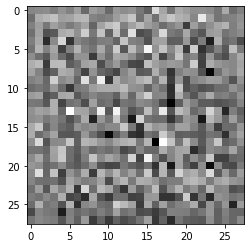

In [8]:
latent_dim=100
generator = create_generator()
noise=tf.random.normal([1,latent_dim])
generated_image = generator (noise, training=False)
plt.imshow (generated_image[0, :, :, 0], cmap='gray')

Le discriminateur est un CNN assez classique dans lequel en entrée il a des images de taille 28x28 et en sortie il possède un neurone avec comme fonction d'activation une sigmoid afin de déterminer s'il s'agit d'une image réelle ou générée. 

In [9]:
def create_discriminator():
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=[28,28,1]))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.3))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

Le modèle pour le discriminateur est :       

In [10]:
model_discriminator=create_discriminator()
model_discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)             

Même s'il n'a pas encore appris on peut le tester sur l'image générée précédente :    

In [11]:
discriminator=create_discriminator()
prediction=discriminator(generated_image)
print (prediction)

tf.Tensor([[0.47208416]], shape=(1, 1), dtype=float32)


Nous pouvons le tester sur les images de Fashion Mnist pour voir si le modèle est capable de bien apprendre. Pour cela il faut définir quelques fonctions utiles :     

In [12]:
# Chargement et normalisation des données
def load_data():
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (X_train, _), (_, _) = fashion_mnist.load_data()
	
  # Ajout d'une dimension pour le canal (1)
  X = expand_dims(X_train, axis=-1)
  # Normalisation
  X = X.astype('float32')
  X = X / 255.0
  return X

# Creation d'un jeu de données de vraies images
# les vraies images sont labélisées avec 1
def generate_real_samples(dataset, nb_images):
	# tirage aléatoire
	ix = randint(0, dataset.shape[0], nb_images)
	# sélection des images
	X = dataset[ix]
	# mettre 1 comme label de classe
	y = ones((nb_images, 1))
	return X, y

# Création d'un faux jeu de données 
# elles seront labélisées avec 0
def generate_fake_samples(nb_images):
  # generation de nombres aléatoires entre 0 et 1
  # attention ici on simplifie en mettant la taille de l'image
  # normalement il faut prendre latent_dim
  X = np.random.rand(28 * 28 * nb_images)
  # reshape en images grises
  X = X.reshape((nb_images, 28, 28, 1))
  # mettre 0 comme label de classe
  y = zeros((nb_images, 1))
  return X, y  

Contrairement à ce que nous faisons d'habitude nous n'allons pas faire un fit mais construire l'entraînement du modèle. En d'autres termes nous ré-écrivons la fonction *fit*. Pour cela il faut boucler sur le nombre d'epochs (en fait ici il ne s'agit pas vraiment d'epoch car nous ne lançons qu'un batch par passage dans la boucle et non pas un passage sur l'ensemble du jeu de données) et lancer l'entraînement du modèle par batch. Ici nous envoyons au modèle un batch d'images réelles puis un batch de fausses images (elles sont de la même qualité que l'image précédente) car il n'y a aucun report de l'erreur sur le générateur. Cela nous permet d'évaluer l'accuracy du modèle pour les vraies et fausses images.   

Nous utilisons la méthode *train_on_batch*. L'avantage de cette méthode est qu'elle va mettre à jour l'ensemble des poids en fonction des données que nous lui fournissons. Elle est par exemple utilisée lorsque vous avez déjà un modèle appris et que vous récupérez des données que vous n'avez jamais vu : elle va adapter les poids de votre modèle entraîné pour prendre en considération ces nouvelles données.  *fit* permet de considérer tout le jeu de données et parfois il est bien utile de pouvoir mettre à jour un modèle uniquement sur des nouvelles données et ne pas relancer l'apprentissage complet en intégrant les nouvelles données. 

In [13]:
# train the discriminator model
def train_discriminator(model, dataset, epochs=100, batchsize=256):
  # on constitue un jeu de données de batchsize/2 images réelles et images fausses
	half_batch = int(batchsize / 2)
	# boucler sur les epochs
	for i in range(epochs):
		# sélection d'images réelles
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# mettre à jour le discriminateur avec les images réelles
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generation de fausses images 
		X_fake, y_fake = generate_fake_samples(half_batch)
		# mise à jour du discriminateur avec de fausses images 
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# Affichage des résultats pour l'accuracy des vraies et des fausses
		print('>%d accuracy_real=%.0f%% accuracy_fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

Il suffit à présent de lancer le modèle :    

**Remarque** ici on met un nombre d'epochs faible (**pensons CO2**) c'est juste pour voir si l'accuracy augmente bien. Si vous mettez un nombre d'epochs à 100 vous verrez que le modèle arrive à 100% pour les deux : il est capable de faire la distinction entre les vraies images et les fausses.

In [14]:
nb_images_total=256 # 128 images de chaque classe
epochs=10

# chargement du modèle
model = create_discriminator()


# chargement des données
dataset=load_data()

# lancement de l'entrainement du discriminateur
train_discriminator(model, dataset, epochs, nb_images_total)

4431872/4422102 [==============================] - 0s 0us/step
>1 accuracy_real=97% accuracy_fake=0%
>2 accuracy_real=95% accuracy_fake=1%
>3 accuracy_real=93% accuracy_fake=3%
>4 accuracy_real=95% accuracy_fake=5%
>5 accuracy_real=98% accuracy_fake=12%
>6 accuracy_real=95% accuracy_fake=18%
>7 accuracy_real=91% accuracy_fake=40%
>8 accuracy_real=89% accuracy_fake=50%
>9 accuracy_real=90% accuracy_fake=72%
>10 accuracy_real=85% accuracy_fake=91%


Maintenant que nous avons testé le générateur et le discriminateur, nous pouvons construire le GAN. Celui-ci va prendre une partie générateur et une partie discriminateur. Attention il est important de reporter l'erreur de la sortie du discriminateur vers le générateur pour que celui-ci puisse modifier ses poids et améliorer l'image. De la même manière l'objectif ici n'est pas de modifier les poids du discriminateur mais plutôt d'envoyer vers l'arrière, i.e. le générateur, la descente de gradient. Pour cela on empêche le modèle d'apprendre le poids de l'erreur du GAN sur le discriminateur.   

**Remarque** : si le discriminateur ne met pas à jour ses poids comment peut il s'améliorer alors qu'au départ les poids du discriminateur sont aléatoires ? **ce qu'il faut comprendre** la réponse à cette question est tout simplement dans l'utilisation de la méthode *train_on_batch*. Ce que nous voulons ici c'est que ce soit le generateur qui mette à jour ses poids. Par contre comme nous avons vu dans la fonction *train_discriminateur* en passant par *train_on_batch* les poids du discriminateur seront automatiquement mis à jour mais pas les erreurs remontées par le GAN.


In [15]:
def create_gan(generator_model, discriminator_model):
  # mettre les poids du discriminateur non entrable
  discriminator_model.trainable = False
  # un seul modele qui regroupe 
  model = Sequential()
  # ajout du générateur
  model.add(generator_model)
  # ajout du discriminateur
  model.add(discriminator_model)

  opt = Adam(learning_rate=0.0003, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

Le modèle GAN final ressemble à ceci :

In [16]:
latent_dim = 100

# creation du générateur
generator_model = create_generator(latent_dim)
# creation du discriminateur
discriminator_model = create_discriminator()

# creation du gan
gan_model = create_gan(generator_model, discriminator_model)

gan_model.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 28, 28, 1)         1190401   
                                                                 
 sequential_6 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,231,106
Trainable params: 1,177,345
Non-trainable params: 53,761
_________________________________________________________________


Avant de finaliser l'entraînement du générateur et du discriminateur puis du GAN, nous définissons quelques fonctions utiles dans un contexte plus général que précédemment. Une fonction *generate_latent_points*pour générer dees données (i.e. pour générer un vecteur) aléatoires, une fonction pour génerer de fausses images, *generate_fake_samples_for_generator* dont l'objectif est à partir de points latent de prédire le résultat, i.e la sortie du modèle pour cela on prédit la sortie associée à une entrée aléatoire, une fonction *save_plot* qui affiche à différentes epochs les images générées, une fonction *evaluate_model* qui simule l'évaluation d'un jeu de test (i.e. le jeu de données validation dans un fit). Cette dernière n'est pas appelée à toutes les étapes pour gagner du temps.  

In [17]:

def generate_latent_points (latent_dim, nb_images):
  X_input = np.random.randn(latent_dim * nb_images)
  X_input = X_input.reshape(nb_images, latent_dim)
  return X_input

def generate_fake_samples_for_generator(generator_model, latent_dim, nb_images):
  # generation des points 
  X_input = generate_latent_points (latent_dim,nb_images)
  # prediction de la sortie du générateur
  X = generator_model.predict(X_input)
  # A ce niveau on considère que les images sont fausses
  # donc on met 0 comme label. 
  y = zeros((nb_images, 1))
  return X, y    

def plot_and_save_generatedimages(generated_images, epoch, nb_images=10):
	# Affichage des images
	for i in range(nb_images * nb_images):
		pyplot.subplot(nb_images, nb_images, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(generated_images[i, :, :, 0], cmap='gray_r')
	# sauvegarde de l'image
	filename = 'generated_plot_FashionCNN_withGan%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 


def evaluate_model (dataset, epoch, generator_model, discriminator_model, latent_dim, nb_images=100, save_model=True):
  # récupération de vraies images pour le discriminateur
  X_real, y_real = generate_real_samples(dataset, nb_images)
  # Evaluation de l'accuracy pour le discriminateur
  _, acc_real = discriminator_model.evaluate(X_real, y_real, verbose=0)

  # génération de fausses images pour le générateur et donc le gan
  X_fake, y_fake = generate_fake_samples_for_generator(generator_model, latent_dim, nb_images)
  # Evaluation du discriminateur avec des fausses images
  _, acc_fake = discriminator_model.evaluate(X_fake, y_fake, verbose=0)

  print ('Accuracy reélle : %.0f%%, fausse : %.0f%%' % (acc_real*100, acc_fake*100))
  
  plot_and_save_generatedimages(X_fake, epoch)
  if save_model==True:
    # sauvegarde du generateur pour un autre usage
    filename = 'generator_model_FashionMNIST%03d.h5' % (epoch + 1)
    generator_model.save(filename)
  



In [18]:
# train the generator and discriminator
def train(generator_model, discriminator_model, gan_model, dataset, latent_dim, epochs=100, batchsize=256):
  # Pour déterminer combien il y aura de batchs analysés à chaque epoch
  batches_per_epoch = int(dataset.shape[0] / batchsize)

  # pour récupérer le même nombre d'images fausses et vraies
  half_batch = int(batchsize / 2)

  for i in range(epochs):
    # parcours des batches pour chaque pas d'epoch
    for j in range(batches_per_epoch):

      # PARTIE DISCRIMINATOR
      #tirage aléatoire de half_batch images vraies
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generation de half_size fausses images
      X_fake, y_fake = generate_fake_samples_for_generator(generator_model, latent_dim, half_batch)
      # vstack permet de concaténer les vraies et fausses images dans X (resp. dans y)
      # on aurait pu utiliser np.concatenate (np.concatenate([X_real, X_fake]))
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

      # la ligne suivante permet au discriminateur de mettre à jour ses poids
      # attention dans le GAN il ne peut pas aprendre donc il ne peut le faire qu'ici
      discriminator_loss,_  = discriminator_model.train_on_batch(X, y)

      # PARTIE GENERATOR ET DONC DE L'ENTREE DU GAN
      # Création des points comme entrée du générateur 
      # 
      X_for_gan = generate_latent_points(latent_dim, batchsize)
      # On met un 1 pour les labels des fausses images pour faire croire au discriminateur
      # qu'il s'agit de vraies images
      y_for_gan = ones((batchsize, 1))

      # mise à jour des poids du générateur par propagation de l'esseur
      # du discriminateur 
      gan_loss = gan_model.train_on_batch(X_for_gan, y_for_gan)
			# Affichage des loss
      print('epoch %d - batch %d/%d, discriminator_loss=%.3f, generator_loss=%.3f'%(i+1, j+1, batches_per_epoch, discriminator_loss, gan_loss))

    # Toutes les 20 epochs evaluation du modèle et sauvegarde du générateur
    if i==1 or i % 20==0:
        evaluate_model (dataset, i, generator_model, discriminator_model, latent_dim)
      

In [19]:
latent_dim = 100
epochs=100
batchsize=257
# Creation du discriminateur
discrimator_model = create_discriminator()
# Creation du generateur
generator_model = create_generator(latent_dim)
# Creation du GAN
gan_model = create_gan(generator_model, discriminator_model)
# Chargement des données
dataset = load_data()


Il ne reste plus qu'à entraîner le modèle.   

**CO2 !!! Remarque IMPORTANTE** Attention l'apprentissage est très long. Si vous voulez le faire il faudra décommenter la cellule suivante pour entraîner le modèle.   
Pour éviter de consommer inutilement du CO2, le modèle a été appris (utilisation du GPU sous Colab) et sauvegardé. Il est disponible et utilisé dans les cellules d'après. 

In [20]:
# train model
#train(generator_model, discriminator_model, gan_model, dataset, latent_dim, epochs,batchsize)

Comme annoncé précédemment, il est inutile de lancer le code précédent (Merci pour le CO2). Vous pouvez récupérer un modèle appris (utilisation du GPU sur Colab - aller dans le menu Modifier/Paramètres du notebook et sélectionner GPU). Vous pouvez télécharger le modèle : 

In [21]:
!wget https://www.lirmm.fr/~poncelet/Ressources/generator_model_CNNFashion_100epochs.h5

--2022-09-29 20:46:02--  https://www.lirmm.fr/~poncelet/Ressources/generator_model_CNNFashion_100epochs.h5
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4680848 (4.5M) [text/plain]
Saving to: ‘generator_model_CNNFashion_100epochs.h5.4’

generator_model_CNN 100%[===================>]   4.46M  6.28MB/s    in 0.7s    

2022-09-29 20:46:04 (6.28 MB/s) - ‘generator_model_CNNFashion_100epochs.h5.4’ saved [4680848/4680848]



Voici un exemple de données générées avec le modèle qui a été appris au cours des epochs :     

EPOCH 1
<IMG SRC="http://www.lirmm.fr/~poncelet/Ressources/generated_plot_e001.png" align="center" >

EPOCH 30 
<IMG SRC="http://www.lirmm.fr/~poncelet/Ressources/generated_plot_e030.png" align="center" >

EPOCH 70
<IMG SRC="http://www.lirmm.fr/~poncelet/Ressources/generated_plot_e070.png" align="center" >

EPOCH 100
<IMG SRC="http://www.lirmm.fr/~poncelet/Ressources/generated_plot_e100.png" align="center" >

Il suffit alors de charger le modèle appris pour générer des images :    

In [22]:
model = load_model('generator_model_CNNFashion_100epochs.h5')

Pour voir comment une image est générée il suffit de générer un vecteur de latent_dim et de le passer dans le modèle pour voir l'image finale associée. 

In [23]:
# Création d'un vecteur aléatoire de taille latent_dim
latent_points = generate_latent_points(100, 1)

Il suffit de prédire l'application du modèle :     

In [24]:
generated_image = model.predict(latent_points)

Affichage de l'image prédite, i.e. de l'image générée : 

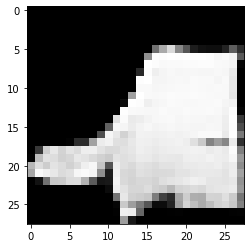

In [25]:
plt.imshow (generated_image[0, :, :, 0], cmap='gray')